In [12]:
import os
import random
from io import BytesIO

import imageio.v3 as iio  # Using imageio v3 for modern API
import matplotlib.pyplot as plt
import numpy
import numpy as np
from PIL import Image
from omero.gateway import BlitzGateway
%matplotlib inline


In [13]:
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public', host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


In [14]:
def print_obj(obj, indent=0):
    """
    Helper method to display info about OMERO objects.
    Not all objects will have a "name" or owner field.
    """
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()))

In [15]:
def load_numpy_array(image, target_x_dim=1024, target_y_dim=1024):
    """
    Loads a microscopy image into a NumPy array, applying random cropping
    if the image dimensions exceed specified limits, and choosing Z and T
    planes randomly. This version loads only the cropped region efficiently.

    Args:
        image: An OMERO image object (e.g., omero.gateway.ImageWrapper)
               from which to load pixel data and metadata.
        target_x_dim (int): The maximum desired X dimension. If the image
                            is larger, it will be cropped to this size.
        target_y_dim (int): The maximum desired Y dimension. If the image
                            is larger, it will be cropped to this size.

    Returns:
        numpy.ndarray: The loaded (and potentially cropped) image data
                       reshaped to (1, size_c, 1, cropped_size_y, cropped_size_x).
        None: If there's an error during processing or if image dimensions are invalid.
    """
    pixels = image.getPrimaryPixels()

    size_z = pixels.getSizeZ()
    size_c = pixels.getSizeC()
    size_t = pixels.getSizeT()
    size_y = pixels.getSizeY()
    size_x = pixels.getSizeX()

    # Ensure dimensions are valid for loading
    if size_z < 1 or size_t < 1 or size_c < 1:
        print(f"Warning: Image {image.getName()} has invalid dimensions (Z:{size_z}, C:{size_c}, T:{size_t}). Cannot load planes.")
        return None

    # Randomly select Z and T planes
    selected_z_plane = random.randint(0, size_z - 1)
    selected_t_timepoint = random.randint(0, size_t - 1)

    s = "t:%s c:%s z:%s y:%s x:%s (selected t:%s z:%s)" % \
        (size_t, size_c, size_z, size_y, size_x, selected_t_timepoint, selected_z_plane)
    print(s)

    # --- Determine Cropping Dimensions and Start Points ---
    # Ensure cropped dimensions don't exceed original dimensions
    cropped_size_y = min(target_y_dim, size_y)
    cropped_size_x = min(target_x_dim, size_x)

    # Calculate random start_y/start_x if original dim is larger than target
    start_y = random.randint(0, size_y - cropped_size_y) if size_y > target_y_dim else 0
    start_x = random.randint(0, size_x - cropped_size_x) if size_x > target_x_dim else 0

    # --- Efficiently Load Only the Cropped Region ---
    loaded_planes = []
    print(f"Downloading image {image.getName()} (cropped region: X={start_x}-{start_x+cropped_size_x}, Y={start_y}-{start_y+cropped_size_y})")
    try:
        for c in range(size_c):
            # --- FIX: Pass Z, C, T, and the tile coordinates as a single tuple ---
            # This signature matches the argument count constraints and the pattern
            # implied by your getTiles example for a single tile.
            tile_coords_tuple = (start_x, start_y, cropped_size_x, cropped_size_y)

            # The assumed getTile() signature is now:
            # getTile(z, c, t, (x, y, width, height))
            plane_data = pixels.getTile(
                selected_z_plane, c, selected_t_timepoint, tile_coords_tuple
            )
            loaded_planes.append(plane_data)

        # Stack the loaded tiles. Shape will be (size_c, cropped_size_y, cropped_size_x)
        all_channels_cropped_data = numpy.stack(loaded_planes)

    except Exception as e:
        print(f"Error loading cropped planes for image {image.getName()}: {e}")
        return None

    # Reshape to (1, size_c, 1, cropped_size_y, cropped_size_x)
    final_shape = (1, size_c, 1, cropped_size_y, cropped_size_x)
    return numpy.reshape(all_channels_cropped_data, newshape=final_shape)

Checking project idr0149-batty-sisterchromatids/experimentB
Imaging Method: array-scan confocal microscopy
Project:2752  Name:"idr0149-batty-sisterchromatids/experimentB" (owner=demo)
Dataset:18063  Name:"CTRL_G2" (owner=demo)
Image:14873029  Name:"220211_5389_2096_c1_rep2_ctrl_hemi_g2_zoom4_8-02-24.tif_registered.tif" (owner=demo)


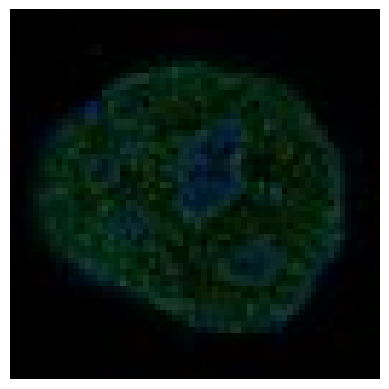

In [21]:
projects = list(conn.getObjects("Project"))

# Define the attribute and the value you're looking for
attribute_name = "Imaging Method"
# Define your search terms as a list
search_terms = ["fluorescence", "confocal"]

foundProject = False

while not foundProject:
    random_project = random.choice(projects)
    print(f'Checking project {random_project.getName()}')
    kv_annotations = random_project.listAnnotations()  # or specific namespace if known
    for annotation in kv_annotations:
        if hasattr(annotation, 'getMapValue'):  # check if it's a MapAnnotation
            for key_value_pair in annotation.getMapValue():
                key = key_value_pair.name
                value = key_value_pair.value
                if key == attribute_name:
                    print(f'{key}: {value}')
                    if any(term.lower() in value.lower() for term in search_terms):
                        datasets = list(random_project.listChildren())
                        random_dataset = random.choice(datasets)
                        images = list(random_dataset.listChildren())
                        random_image = random.choice(images)
                        if random_image.getPrimaryPixels().getSizeC() > 1:
                            foundProject = True
                            break

print_obj(random_project)
print_obj(random_dataset)
print_obj(random_image)

raw_thumb = random_image.getThumbnail()
rendered_thumb = Image.open(BytesIO(raw_thumb))

# Display the thumbnail using Matplotlib
plt.imshow(rendered_thumb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [22]:
data = load_numpy_array(random_image)

t:1 c:4 z:72 y:772 x:772 (selected t:0 z:49)


In [23]:
def generate_crosstalk_data(pure_target_channel: np.ndarray, pure_source_channel: np.ndarray,
                            crosstalk_coefficient: float) -> tuple[np.ndarray, np.ndarray]:
    if not (0.0 <= crosstalk_coefficient <= 1.0):
        print("Warning: Crosstalk coefficient is typically between 0 and 1.")

    if pure_target_channel.shape != pure_source_channel.shape:
        raise ValueError("Pure target and source channel images must have the same shape.")

    # Ensure inputs are float to allow for scaling and addition
    pure_target_channel = pure_target_channel.astype(np.float64)
    pure_source_channel = pure_source_channel.astype(np.float64)

    # Calculate the bleed-through signal
    bleed_through_signal = crosstalk_coefficient * pure_source_channel

    # Generate the mixed target channel image
    mixed_target_channel = pure_target_channel + bleed_through_signal

    # The ground truth crosstalk map is simply the bleed-through signal itself
    ground_truth_crosstalk_map = bleed_through_signal

    return mixed_target_channel, ground_truth_crosstalk_map

In [24]:
def save_images(image: np.ndarray, filename: str):
    """
    Saves a NumPy array as a TIFF image.
    Handles appropriate data type conversion for saving.
    """
    # Imageio can handle float32 directly for TIFF.
    iio.imwrite(filename, image, extension='.tif')
    print(f"Saved {filename}")

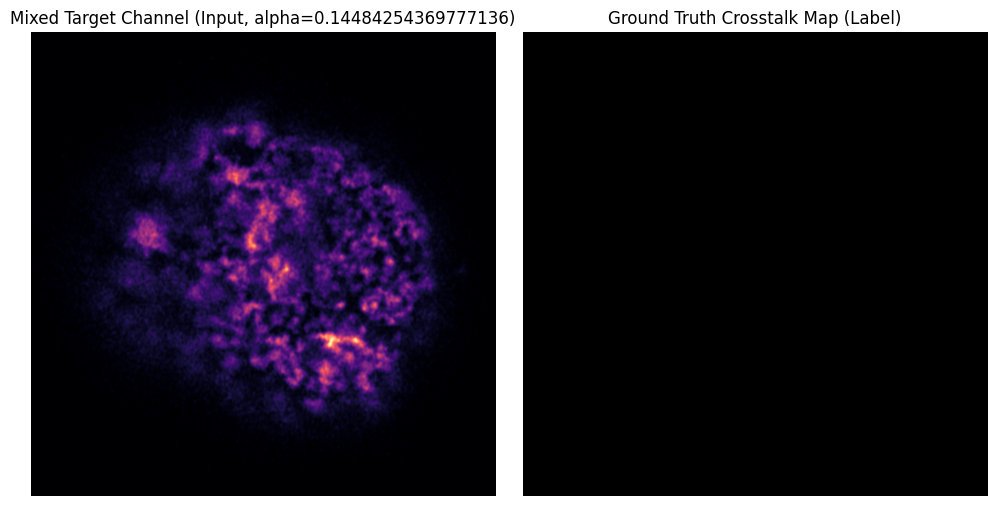

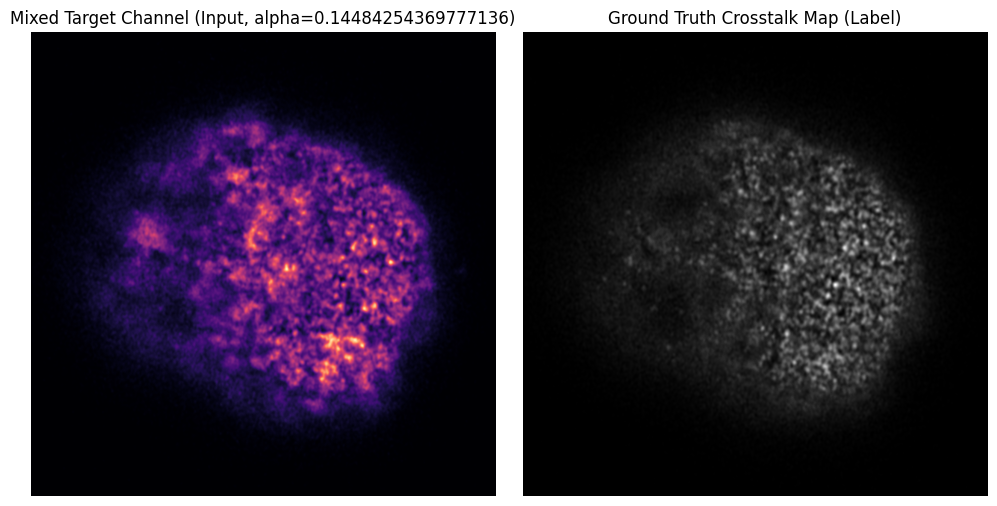


Generated and saved 2 pairs of images to 'crosstalk_training_data/'


In [29]:
if data is not None:
    # Create directories for saving
    output_dir = "crosstalk_training_data"
    input_dir = os.path.join(output_dir, "inputs")
    labels_dir = os.path.join(output_dir, "labels")

    #os.makedirs(input_dir, exist_ok=True)
    #os.makedirs(labels_dir, exist_ok=True)

    source_channel = random.choice(range(np.size(data[0], 0)))
    target_channel = source_channel

    while source_channel == target_channel:
        target_channel = random.choice(range(np.size(data[0], 0)))

    # Define a set of crosstalk coefficients to generate diverse data
    crosstalk_coefficients = [0.0, random.random() * 0.4]  # Include no crosstalk (0.0)

    for i, alpha in enumerate(crosstalk_coefficients):
        mixed_image, true_crosstalk_map = generate_crosstalk_data(
            pure_target_channel=data[0, target_channel, 0],
            pure_source_channel=data[0, source_channel, 0],
            crosstalk_coefficient=alpha
        )

        # Generate unique filenames
        input_filename = os.path.join(input_dir, f"sample_{i:03d}__alpha_{alpha:.2f}_input.tif")
        label_filename = os.path.join(labels_dir, f"sample_{i:03d}_alpha_{alpha:.2f}_label.tif")

        # Save the generated images
        #save_images(mixed_image, input_filename)
        #save_images(true_crosstalk_map, label_filename)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(mixed_image, cmap='magma')
        axes[0].set_title(f'Mixed Target Channel (Input, alpha={crosstalk_coefficients[-1]})')
        axes[0].axis('off')

        axes[1].imshow(true_crosstalk_map, cmap='gray')
        axes[1].set_title('Ground Truth Crosstalk Map (Label)')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    print(f"\nGenerated and saved {len(crosstalk_coefficients)} pairs of images to '{output_dir}/'")
else:
    print("Image too big!")